<a href="https://colab.research.google.com/github/mukkatharun/advance-deep-learning-assignments/blob/main/assignment2_GraphNeuralNetworks/Node_classification_using_Graph_Convolutional_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required packages

In [150]:
pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing the required libraries

In [151]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Loading the Cora dataset

In [152]:
dataset = sg.datasets.Cora()
G, node_subjects = dataset.load()

In [153]:
node_subjects.head()

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
Name: subject, dtype: object

In [154]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


Data Splitting

In [155]:
train, test = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test = model_selection.train_test_split(
    test, train_size=500, test_size=None, stratify=test
)

In [156]:
train.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


Converting to numeric arrays

In [157]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test)

GCN layers creation

In [158]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [159]:
train_gen = generator.flow(train.index, train_targets)

In [160]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [161]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices_5')>

In [162]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

Modelling

In [163]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [164]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [165]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [166]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/100
1/1 - 2s - loss: 1.9491 - acc: 0.1643 - val_loss: 1.9178 - val_acc: 0.2900 - 2s/epoch - 2s/step
Epoch 2/100
1/1 - 0s - loss: 1.8983 - acc: 0.3214 - val_loss: 1.8800 - val_acc: 0.3800 - 140ms/epoch - 140ms/step
Epoch 3/100
1/1 - 0s - loss: 1.8552 - acc: 0.4214 - val_loss: 1.8297 - val_acc: 0.4400 - 195ms/epoch - 195ms/step
Epoch 4/100
1/1 - 0s - loss: 1.7861 - acc: 0.4857 - val_loss: 1.7716 - val_acc: 0.4820 - 201ms/epoch - 201ms/step
Epoch 5/100
1/1 - 0s - loss: 1.7169 - acc: 0.5357 - val_loss: 1.7060 - val_acc: 0.5280 - 206ms/epoch - 206ms/step
Epoch 6/100
1/1 - 0s - loss: 1.6111 - acc: 0.5429 - val_loss: 1.6354 - val_acc: 0.5540 - 220ms/epoch - 220ms/step
Epoch 7/100
1/1 - 0s - loss: 1.5388 - acc: 0.5500 - val_loss: 1.5589 - val_acc: 0.5700 - 241ms/epoch - 241ms/step
Epoch 8/100
1/1 - 0s - loss: 1.4203 - acc: 0.5929 - val_loss: 1.4746 - val_acc: 0.6180 - 276ms/epoch - 276ms/step
Epoch 9/100
1/1 - 0s - loss: 1.3455 - acc: 0.5929 - val_loss: 1.3871 - val_acc: 0.6500 - 291ms

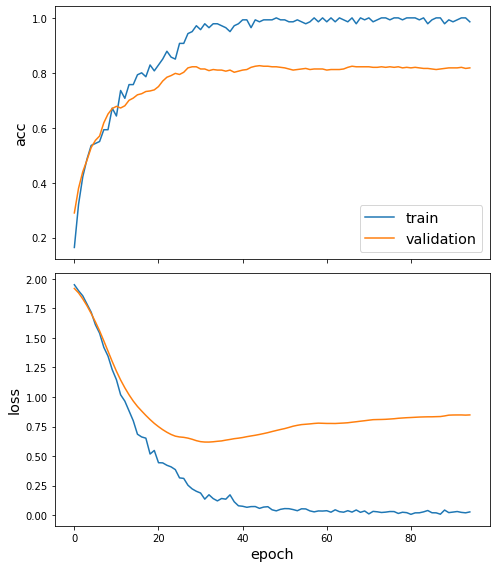

In [167]:
sg.utils.plot_history(history)

Calculting Test Metrics

In [168]:
test_gen = generator.flow(test.index, test_targets)

In [169]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 54ms/step - loss: 0.9836 - acc: 0.7790

Test Set Metrics:
	loss: 0.9836
	acc: 0.7790


Predictions

In [170]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 159ms/step


In [171]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [172]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(5)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Theory,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods


Node embeddings

In [173]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [174]:
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 0s 125ms/step


(1, 2708, 16)

Dimensional Reduction

As the GCN layer gave 16 dimension output, i am reducing the dimensions so it will be easy for plotting 

In [175]:
transform = TSNE

In [176]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [177]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

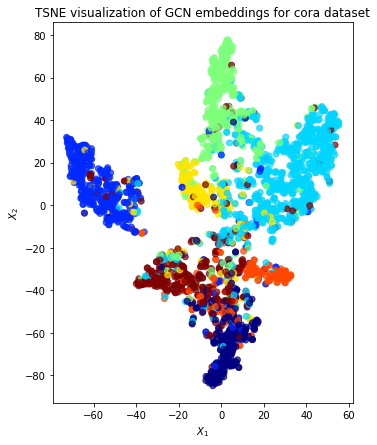

In [178]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)